In [17]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pyrosetta as py

%matplotlib inline

In [18]:
py.init("-mute all")

PyRosetta-4 2020 [Rosetta PyRosetta4.conda.linux.cxx11thread.serialization.CentOS.python37.Release 2020.50+release.1295438cd4bd2be39c9dbbfab8db669ab62415ab 2020-12-12T00:30:01] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.


In [19]:
import glob
import os

In [4]:
# First step: check that the hydrogen bond of the motif is still present after relaxation. We start with 2493 designs.

hbond_set = py.rosetta.core.scoring.hbonds.HBondSet()
pdbs_list = []

for pdb_i in glob.glob("*_input_*.pdb"):
    hbonds = {'acc':[], 'don':[]}
    folder = os.path.splitext(pdb_i)[0]
    with open(pdb_i, 'r') as fi:
        for line in fi:
            if "HBNet" in line:
                if int(line.split()[2]) in [26,114] :
                    hbonds['don'].append(int(line.split()[2]))
                else:
                    hbonds['acc'].append(int(line.split()[2]))
    t = len(hbonds['don'])*10
    n = 0
    for i in range(1,11):
        design = folder + '/' + folder + '_' + "{:04d}".format(i) + '.pdb'
        pose = py.pose_from_pdb(design)
        pose.update_residue_neighbors()
        py.rosetta.core.scoring.hbonds.fill_hbond_set(pose, False, hbond_set)
        for hb in range(1, hbond_set.nhbonds()+1):
            if hbond_set.hbond(hb).don_res() in hbonds['don'] and hbond_set.hbond(hb).acc_res() in hbonds['acc'] and hbond_set.hbond(hb).don_hatm_is_backbone() == False and hbond_set.hbond(hb).acc_atm_is_backbone() == False:
                n += 1
    if n/t >= 0.6:
        pdbs_list.append(pdb_i)
print(len(pdbs_list))




993


In [6]:
# Total: 1520 designed kept at this stage

#import pickle
#with open("pdbs_stable_motifs.csv", 'w') as out_f:
#    for i in pdbs_list:
#        out_f.write(i+"\n")
pdbs_list = []

with open("pdbs_stable_motifs.csv", 'r') as in_f:
    for line in in_f:
        pdbs_list.append(line.strip())

print(len(pdbs_list))
        
#with open('pdbs_list.pkl', 'rb') as f:
#    pdbs_list = pickle.load(f)

993


In [7]:
# Step 2: Out of the pre-filtered set, which ones have have a good stabilization of the motif (energy of the residues in the motif does not change much after relaxation).
energy_diff = {}
for pdb in pdbs_list:
    folder = os.path.splitext(pdb)[0]
    HBNet = []
    energy_table_A = []
    tot_energy_A = 0
    mean_energy_A = 0
    tot_hbond_A = 0
    mean_hbond_A = 0
    labels = []
    with open(pdb, 'r') as pdb_f:
        for line in pdb_f:
            if "HBNet" in line and int(line.split()[2]) != 26 and int(line.split()[2]) != 114 :
                HBNet.append(int(line.split()[2]))
            elif line.startswith("#BEGIN_POSE_ENERGIES_TABLE"):
                labels = pdb_f.readline().strip().split(' ')
                next(pdb_f)
                next(pdb_f)
                for line in pdb_f:
                    if line.startswith("#END_POSE_ENERGIES_TABLE"):
                        break
                    energy_table_A.append(line.strip().split(' '))
    da = pd.DataFrame(energy_table_A, columns=labels)
    da['label'] = da['label'].str.replace('HIS_D', 'HIS')
    new_c = da['label'].str.split('_', expand=True)
    da['resn'] = new_c[1].astype(int) 
    tot_energy_A = da['total'].loc[da['resn'].isin(HBNet)].astype(float).sum()
    mean_energy_A = tot_energy_A/len(HBNet)
    tot_hbond_A = da['hbond_sc'].loc[da['resn'].isin(HBNet)].astype(float).sum()
    mean_hbond_A = tot_hbond_A/len(HBNet)    
    
    for i in range(1,11):
        design = folder + '/' + folder + '_' + "{:04d}".format(i) + '.pdb'
        tot_energy_B = 0
        mean_energy_B = 0
        tot_hbond_B = 0
        mean_hbond_B = 0
        energy_table_B = []    
        diff_energy = 0
        diff_hbond = 0
        with open(design, 'r') as fi:
            for line in fi:
                if line.startswith("#BEGIN_POSE_ENERGIES_TABLE"):
                    next(fi)
                    next(fi)
                    next(fi)
                    for line in fi:
                        if line.startswith("#END_POSE_ENERGIES_TABLE"):
                            break
                        energy_table_B.append(line.strip().split(' '))
        db = pd.DataFrame(energy_table_B, columns=labels)
        db['label'] = db['label'].str.replace('HIS_D', 'HIS')
        new_c = db['label'].str.split('_', expand=True)
        db['resn'] = new_c[1].astype(int)
        tot_energy_B = db['total'].loc[db['resn'].isin(HBNet)].astype(float).sum()
        mean_energy_B = tot_energy_B/len(HBNet)
        tot_hbond_B = db['hbond_sc'].loc[db['resn'].isin(HBNet)].astype(float).sum()
        mean_hbond_B = tot_hbond_B/len(HBNet)
        diff_energy = mean_energy_A - mean_energy_B
        diff_hbond = mean_hbond_A - mean_hbond_B
        energy_diff[design] = (diff_energy, diff_hbond)
de = pd.DataFrame.from_dict(energy_diff, orient='index', columns=['diff_energy','diff_hbond'])
print(de)

                                                    diff_energy  diff_hbond
43_input_0013_0004_0005_0003/43_input_0013_0004...    -2.239960    0.024490
43_input_0013_0004_0005_0003/43_input_0013_0004...    -2.003485    0.013850
43_input_0013_0004_0005_0003/43_input_0013_0004...    -1.947975    0.026275
43_input_0013_0004_0005_0003/43_input_0013_0004...    -2.020845    0.010440
43_input_0013_0004_0005_0003/43_input_0013_0004...    -2.006925    0.005695
...                                                         ...         ...
24_input_0139_0005_0006_0003/24_input_0139_0005...    -2.756280   -0.027390
24_input_0139_0005_0006_0003/24_input_0139_0005...    -2.736790   -0.015540
24_input_0139_0005_0006_0003/24_input_0139_0005...    -2.702750   -0.011260
24_input_0139_0005_0006_0003/24_input_0139_0005...    -2.683245   -0.027955
24_input_0139_0005_0006_0003/24_input_0139_0005...    -2.622855   -0.012330

[9930 rows x 2 columns]


In [8]:

de['design'], de['surface'] = de.index.str.split('/',1).str

print(de)


                                                    diff_energy  diff_hbond  \
43_input_0013_0004_0005_0003/43_input_0013_0004...    -2.239960    0.024490   
43_input_0013_0004_0005_0003/43_input_0013_0004...    -2.003485    0.013850   
43_input_0013_0004_0005_0003/43_input_0013_0004...    -1.947975    0.026275   
43_input_0013_0004_0005_0003/43_input_0013_0004...    -2.020845    0.010440   
43_input_0013_0004_0005_0003/43_input_0013_0004...    -2.006925    0.005695   
...                                                         ...         ...   
24_input_0139_0005_0006_0003/24_input_0139_0005...    -2.756280   -0.027390   
24_input_0139_0005_0006_0003/24_input_0139_0005...    -2.736790   -0.015540   
24_input_0139_0005_0006_0003/24_input_0139_0005...    -2.702750   -0.011260   
24_input_0139_0005_0006_0003/24_input_0139_0005...    -2.683245   -0.027955   
24_input_0139_0005_0006_0003/24_input_0139_0005...    -2.622855   -0.012330   

                                                   

/software/conda/envs/pyrosetta/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  """Entry point for launching an IPython kernel.


/software/conda/envs/pyrosetta/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


-2.7566839607250753


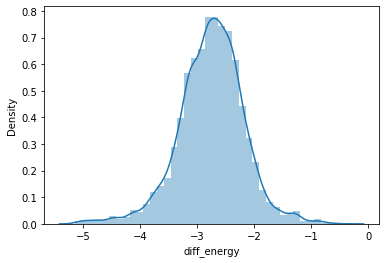

In [9]:
sns.distplot(de["diff_energy"], bins=40)
print(de['diff_energy'].mean())

/software/conda/envs/pyrosetta/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


0.01629994159113797


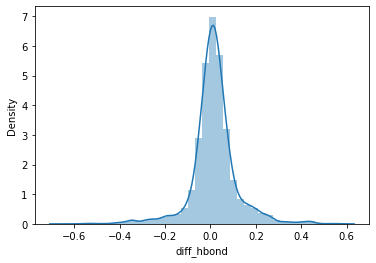

In [10]:
sns.distplot(de["diff_hbond"], bins=40)
print(de['diff_hbond'].mean())

/software/conda/envs/pyrosetta/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


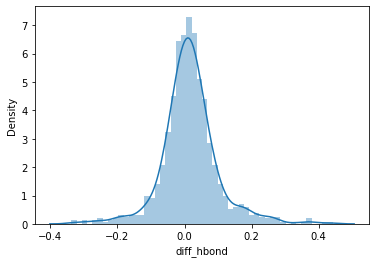

In [11]:
sns.distplot(de.groupby('design').mean()['diff_hbond'])

/software/conda/envs/pyrosetta/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


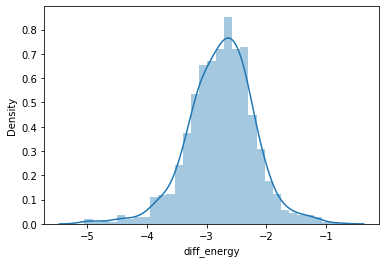

In [12]:
sns.distplot(de.groupby('design').mean()['diff_energy'])

In [13]:
dmean = de.groupby('design').mean()
print(dmean)

                              diff_energy  diff_hbond
design                                               
0_input_0069_0003_00010_0001    -1.707641   -0.084734
0_input_0069_0003_0006_0004     -2.327546   -0.054886
0_input_0069_0003_0008_0004     -2.613980    0.090672
0_input_0069_0005_0004_0001     -1.447448    0.016608
0_input_0071_0002_0005_0003     -3.358300    0.013535
...                                   ...         ...
9_input_0062_0004_0006_0005     -2.619811    0.053290
9_input_0062_0004_0008_0002     -2.749394    0.020827
9_input_0062_0004_0008_0003     -3.217216   -0.021769
9_input_0062_0004_0008_0004     -4.452588    0.000650
9_input_0062_0004_0008_0005     -3.350228   -0.110243

[993 rows x 2 columns]


In [14]:
dmean.loc[(dmean['diff_energy'] < 0.1) & (dmean['diff_hbond'] <0.1)].shape

(886, 2)

In [15]:
de["diff_sum"] = de['diff_energy'] + de['diff_hbond']
de["rank"] = de.groupby('design')["diff_sum"].rank(ascending=True)
#de = de.loc[~(de["design"] == "15__input_0005_0005_5_0001")]
#dranked['design'], dranked['surface'] = dranked.index.str.split('/',1).str
print(de)

                                                    diff_energy  diff_hbond  \
43_input_0013_0004_0005_0003/43_input_0013_0004...    -2.239960    0.024490   
43_input_0013_0004_0005_0003/43_input_0013_0004...    -2.003485    0.013850   
43_input_0013_0004_0005_0003/43_input_0013_0004...    -1.947975    0.026275   
43_input_0013_0004_0005_0003/43_input_0013_0004...    -2.020845    0.010440   
43_input_0013_0004_0005_0003/43_input_0013_0004...    -2.006925    0.005695   
...                                                         ...         ...   
24_input_0139_0005_0006_0003/24_input_0139_0005...    -2.756280   -0.027390   
24_input_0139_0005_0006_0003/24_input_0139_0005...    -2.736790   -0.015540   
24_input_0139_0005_0006_0003/24_input_0139_0005...    -2.702750   -0.011260   
24_input_0139_0005_0006_0003/24_input_0139_0005...    -2.683245   -0.027955   
24_input_0139_0005_0006_0003/24_input_0139_0005...    -2.622855   -0.012330   

                                                   

In [ ]:
# Change of plan: many of the filtered-out designs in previous step actually look good. Take all 1020 designs to next stage. 
hbond_set = py.rosetta.core.scoring.hbonds.HBondSet()
designs_list = []

for index, row in dmean.iterrows():
    model = index
#    parent = '_'.join(index.split('_')[:-1])
#    print(parent)
#    score_file = model + "/" + "score.sc"
#    ds = pd.read_csv(score_file, sep='\s+', header=1)
#    cst_i = '../' + parent + '/cst'
    hbonds = {'acc':[], 'don':[]}

    good_designs = []
    with open(model+".pdb", 'r') as fi:
        for line in fi:
            if "HBNet" in line:
                if int(line.split()[2]) in [26,114] :
                    hbonds['don'].append(int(line.split()[2]))
                else:
                    hbonds['acc'].append(int(line.split()[2]))
    t = len(hbonds['don'])

    for i in range(1,11):
        n = 0
        design = model + '/' + model + '_' + "{:04d}".format(i) + '.pdb'
        pose = py.pose_from_pdb(design)
        pose.update_residue_neighbors()
        py.rosetta.core.scoring.hbonds.fill_hbond_set(pose, False, hbond_set)
        for hb in range(1, hbond_set.nhbonds()+1):
            if hbond_set.hbond(hb).don_res() in hbonds['don'] and hbond_set.hbond(hb).acc_res() in hbonds['acc'] and hbond_set.hbond(hb).don_hatm_is_backbone() == False and hbond_set.hbond(hb).acc_atm_is_backbone() == False:
                n += 1
        if n == t :
            good_designs.append(model+'_'+"{:04d}".format(i)+'.pdb')
    print(good_designs)

    top_found = False
    r = 1
    while top_found == False and r < 11:
        print(r)
        top = de.loc[(de["rank"] == r) & (de["design"] == model)].surface.item()
        if top in good_designs:
            top_found = True
            designs_list.append(model+"/"+top)
        else:
            r += 1
            
print(designs_list)
print(len(designs_list))

In [27]:
import pickle

with open('final_picked_pdbs.pkl', 'wb') as f:
    pickle.dump(designs_list, f)

In [20]:
import pickle
with open('final_picked_pdbs.pkl', 'rb') as f:
    designs_list = pickle.load(f)
print(designs_list)

['0_input_0069_0003_00010_0001/0_input_0069_0003_00010_0001_0002.pdb', '0_input_0069_0003_0006_0004/0_input_0069_0003_0006_0004_0004.pdb', '0_input_0069_0003_0008_0004/0_input_0069_0003_0008_0004_0006.pdb', '0_input_0069_0005_0004_0001/0_input_0069_0005_0004_0001_0010.pdb', '0_input_0071_0002_0005_0003/0_input_0071_0002_0005_0003_0004.pdb', '0_input_0071_0003_0005_0001/0_input_0071_0003_0005_0001_0002.pdb', '0_input_0071_0003_0005_0003/0_input_0071_0003_0005_0003_0007.pdb', '0_input_0071_0003_0005_0005/0_input_0071_0003_0005_0005_0006.pdb', '0_input_0084_0005_0009_0004/0_input_0084_0005_0009_0004_0009.pdb', '0_input_0119_0004_00013_0005/0_input_0119_0004_00013_0005_0010.pdb', '0_input_0119_0004_0007_0001/0_input_0119_0004_0007_0001_0001.pdb', '0_input_0119_0005_00013_0003/0_input_0119_0005_00013_0003_0006.pdb', '0_input_0119_0005_00015_0003/0_input_0119_0005_00015_0003_0001.pdb', '0_input_0132_0003_00014_0001/0_input_0132_0003_00014_0001_0002.pdb', '0_input_0132_0003_0007_0001/0_input_

In [21]:
hbond_set = py.rosetta.core.scoring.hbonds.HBondSet()
n= 1
for pdb_file in designs_list:
    print(n)
    n += 1
    model_pdb = os.path.split(pdb_file)[1]
    model_name = os.path.splitext(model_pdb)[0]
    new_path = "../round3_fasol09/"+model_name+"/"
    parent0 = os.path.split(pdb_file)[0]
    parent = '_'.join(parent0.split('_')[:-2]) + "_" + parent0.split('_')[4][3:]
    score_file = parent0 + "/" + "score.sc"
    ds = pd.read_csv(score_file, sep='\s+', header=1)
    cst_i = '../round2_fasol09/' + parent + '/cst'
    cst_lines = ["Dihedral N 29 CA 29 CB 29 CG 29 CIRCULARHARMONIC -3.0 0.20\n",
"Dihedral N 57 CA 57 CB 57 CG 57 CIRCULARHARMONIC -3.0 0.20\n",
"Dihedral N 87 CA 87 CB 87 CG 87 CIRCULARHARMONIC -3.0 0.20\n",
"Dihedral N 119 CA 119 CB 119 CG 119 CIRCULARHARMONIC -3.0 0.20\n",
"Dihedral N 147 CA 147 CB 147 CG 147 CIRCULARHARMONIC -3.0 0.20\n",
"Dihedral N 175 CA 175 CB 175 CG 175 CIRCULARHARMONIC -3.0 0.20\n\n",
"Dihedral N 15 CA 15 CB 15 CG 15 CIRCULARHARMONIC 3.0 0.20\n",
"Dihedral N 41 CA 41 CB 41 CG 41 CIRCULARHARMONIC 3.0 0.20\n",
"Dihedral N 71 CA 71 CB 71 CG 71 CIRCULARHARMONIC 3.0 0.20\n",
"Dihedral N 101 CA 101 CB 101 CG 101 CIRCULARHARMONIC 3.0 0.20\n",
"Dihedral N 133 CA 133 CB 133 CG 133 CIRCULARHARMONIC 3.0 0.20\n",
"Dihedral N 159 CA 159 CB 159 CG 159 CIRCULARHARMONIC 3.0 0.20\n"
]
    resfile_i = '../round2_fasol09/' + parent + '/core.resfile'
    
    try:
        os.mkdir(new_path)
    except OSError:
        print ("Creation of the directory %s failed" % new_path)

    hbonds = {"acc": [], "don": []}
    with open(pdb_file, 'r') as fi:
        for line in fi:
            if "HBNet" in line:
                if int(line.split()[2]) in [26,114] :
                    hbonds['don'].append(int(line.split()[2]))
                else:
                    hbonds['acc'].append(int(line.split()[2]))

    with open(cst_i, 'r') as cst_file_in:
        for line in cst_file_in:
            cst_lines.append(line)
    
    pose = py.pose_from_pdb(pdb_file)
    pose.update_residue_neighbors()
    py.rosetta.core.scoring.hbonds.fill_hbond_set(pose, False, hbond_set)
    
    motif_residues = hbonds["acc"] + hbonds["don"]
    
    for hb in range(1, hbond_set.nhbonds()+1):
        if hbond_set.hbond(hb).acc_res() in hbonds['acc'] and hbond_set.hbond(hb).don_res() not in hbonds['don'] and hbond_set.hbond(hb).don_hatm_is_backbone() == False and hbond_set.hbond(hb).acc_atm_is_backbone() == False:
            interacting_res = hbond_set.hbond(hb).don_res()
            interacting_AA = pose.residue(interacting_res)
            acc_atm = hbond_set.hbond(hb).acc_atm()
            don_hatm = hbond_set.hbond(hb).don_hatm()
            don_atm = pose.residue(hbond_set.hbond(hb).don_res()).first_adjacent_heavy_atom(don_hatm)
            acc_atm_name = pose.residue(hbond_set.hbond(hb).acc_res()).atom_name(acc_atm)
            don_atm_name = pose.residue(hbond_set.hbond(hb).don_res()).atom_name(don_atm)
            cst_line = "AtomPair  %s %s  %s  %s BOUNDED 2.6 3 0.2 hbond\n" %(acc_atm_name, hbond_set.hbond(hb).acc_res(), don_atm_name, hbond_set.hbond(hb).don_res())
            cst_lines.append(cst_line)
            motif_residues.append(interacting_res)
            print(hbond_set.hbond(hb))
    
    motif_residues = list(set(motif_residues))
  
    resfile_lines=[]
    with open(resfile_i, "r") as in_resfile:
        for line in in_resfile:
            if "PIKAA " in line:
                if int(line.split()[0]) in motif_residues:
                    motif= int(line.split()[0])
                    print(motif)
                    resline = "%s A PIKAA %s #core\n" %(str(motif), pose.residue(motif).name1())
                    resfile_lines.append(resline)
                elif "#core" not in line:
                    pass
                else:
                    resfile_lines.append(line)
            else:
                resfile_lines.append(line)
 
    
    cst_lines = list(set(cst_lines))
    new_cst = new_path + "cst"
    with open(new_cst, "w") as out_cst:
        for c_line in cst_lines:
            out_cst.write(c_line)

    new_resfile = new_path + "core.resfile"
    with open(new_resfile, "w") as out_resfile:
        for r_line in resfile_lines:
            out_resfile.write(r_line)
            
            
    new_pdb = new_path + model_pdb
    with open(pdb_file, "r") as in_pdb:
        with open(new_pdb, "w") as out_pdb:
            for line in in_pdb:
                out_pdb.write(line)
                if "TER" in line:
                    break
            for motif in motif_residues:
                out_pdb.write("REMARK PDBinfo-LABEL:   %s HBNet\n" %(motif))
            

1
48 don: protein 12 20 acc: protein 172 8 -0.62833 0.717647

49 don: protein 12 23 acc: protein 172 8 -1.17769 0.717647

48 don: protein 116 20 acc: protein 84 8 -0.978916 0.788235

49 don: protein 116 23 acc: protein 84 8 -0.844275 0.788235

12
116
26
172
84
114
2
47 don: protein 8 20 acc: protein 174 8 -1.15557 0.788235

48 don: protein 116 20 acc: protein 84 8 -0.795546 0.741176

49 don: protein 116 23 acc: protein 84 8 -0.9439 0.741176

8
116
26
174
84
114
3
48 don: protein 116 20 acc: protein 84 8 -0.839667 0.741176

49 don: protein 116 23 acc: protein 84 8 -0.91721 0.741176

116
26
172
84
114
4
48 don: protein 64 20 acc: protein 84 8 -0.523672 0.811765

49 don: protein 64 23 acc: protein 84 8 -1.15981 0.811765

64
26
172
84
114
5
48 don: protein 154 20 acc: protein 174 8 -0.618995 0.811765

49 don: protein 154 23 acc: protein 174 8 -1.25574 0.811765

154
26
174
82
114
6
48 don: protein 12 20 acc: protein 172 8 -1.39295 0.764706

49 don: protein 12 23 acc: protein 172 8 -0.389462

In [24]:
print(de.loc[de['rank'] == 3.5])

                                                    diff_energy  diff_hbond  \
15__input_0005_0005_5_0001/15__input_0005_0005_...      0.08514    0.063445   
15__input_0005_0005_5_0001/15__input_0005_0005_...      0.08514    0.063445   

                                                                        design  \
15__input_0005_0005_5_0001/15__input_0005_0005_...  15__input_0005_0005_5_0001   
15__input_0005_0005_5_0001/15__input_0005_0005_...  15__input_0005_0005_5_0001   

                                                                                surface  \
15__input_0005_0005_5_0001/15__input_0005_0005_...  15__input_0005_0005_5_0001_0001.pdb   
15__input_0005_0005_5_0001/15__input_0005_0005_...  15__input_0005_0005_5_0001_0006.pdb   

                                                    diff_sum  rank  
15__input_0005_0005_5_0001/15__input_0005_0005_...  0.148585   3.5  
15__input_0005_0005_5_0001/15__input_0005_0005_...  0.148585   3.5  
